In [13]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

Initial state of qubit 0:


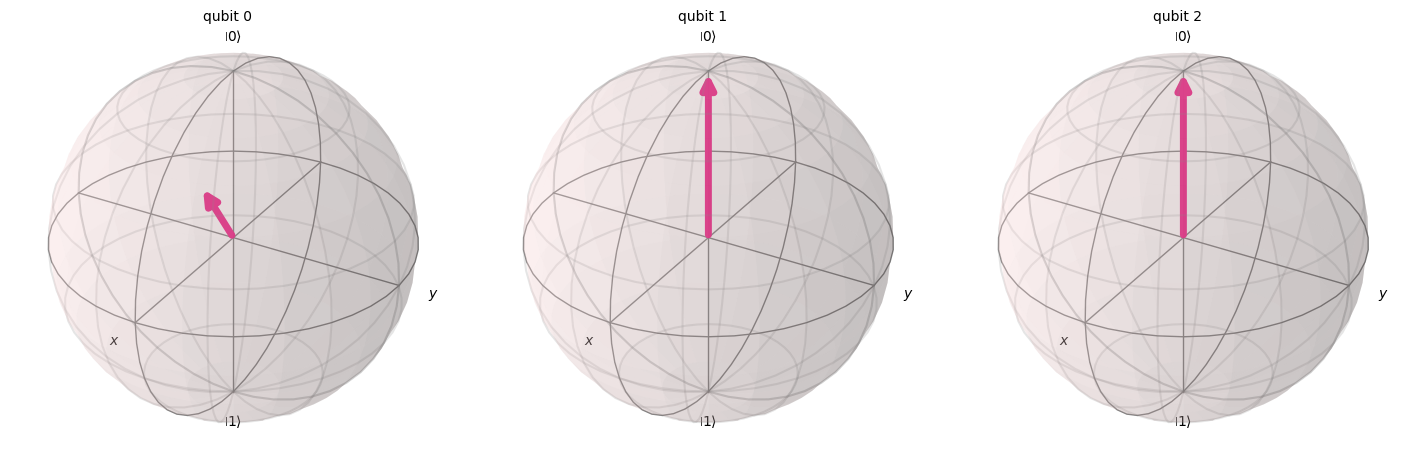

Fidelity between initial and teleported states: 1.000000

Bob’s final qubit (qubit 2) Bloch vector:


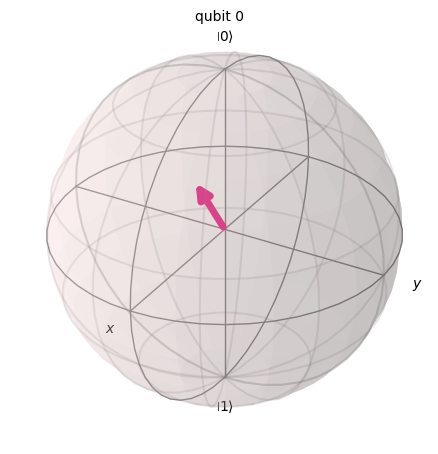

In [2]:
# Quantum Teleportation (Coherent version) – Qiskit 2.x compatible
# Works on modern qiskit-aer simulators

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Build the teleportation circuit
qc = QuantumCircuit(3)

# Prepare arbitrary state |ψ⟩ on qubit 0
theta, phi = 0.8, 0.3
qc.ry(theta, 0)
qc.rz(phi, 0)

# Save initial state for comparison
sv_initial = Statevector.from_instruction(qc)
print("Initial state of qubit 0:")
display(plot_bloch_multivector(sv_initial))

# Create Bell pair between qubits 1 and 2
qc.h(1)
qc.cx(1, 2)

# Bell measurement part (but coherent)
qc.cx(0, 1)
qc.h(0)

# Coherent corrections
qc.cx(1, 2)
qc.cz(0, 2)

# Save final statevector explicitly (Qiskit 2.x requires this)
qc.save_statevector()

# 2️⃣ Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()

# Retrieve the saved statevector
sv_final = result.data(0)["statevector"]
sv_final = Statevector(sv_final)

# 3️⃣ Compare: initial vs Bob’s (qubit 2) final state
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])

# Extract the dominant pure states (since both should be pure)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]

# Compute fidelity
fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
print(f"Fidelity between initial and teleported states: {fidelity:.6f}")

# 4️⃣ Visualize Bloch spheres (fixed)
print("\nBob’s final qubit (qubit 2) Bloch vector:")

# Convert rho_bob (DensityMatrix) → pure statevector (dominant eigenvector)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]  # dominant eigenvector
bob_sv = Statevector(bob_state)

display(plot_bloch_multivector(bob_sv))


=== Teleportation for θ=0.79 rad, φ=0.00 rad ===
Fidelity between initial and teleported states: 1.000000

Initial Qubit (|ψ⟩):


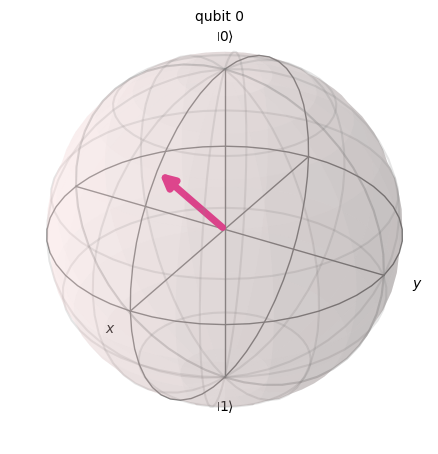

Teleported Qubit (Bob’s qubit):


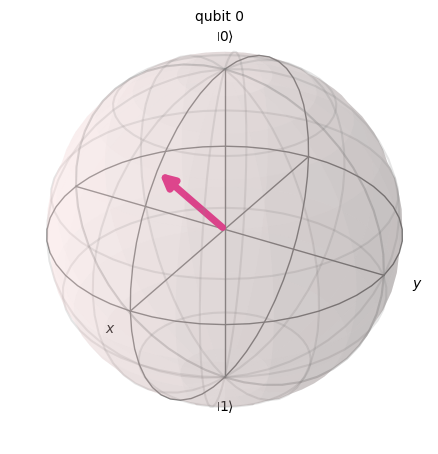


=== Teleportation for θ=1.57 rad, φ=0.79 rad ===
Fidelity between initial and teleported states: 1.000000

Initial Qubit (|ψ⟩):


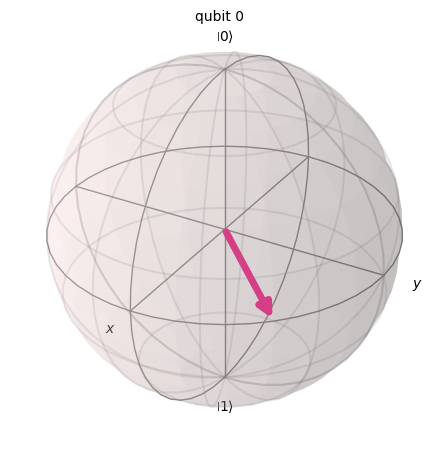

Teleported Qubit (Bob’s qubit):


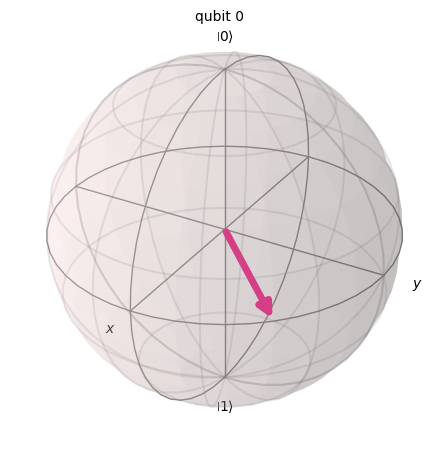


=== Teleportation for θ=1.05 rad, φ=1.57 rad ===
Fidelity between initial and teleported states: 1.000000

Initial Qubit (|ψ⟩):


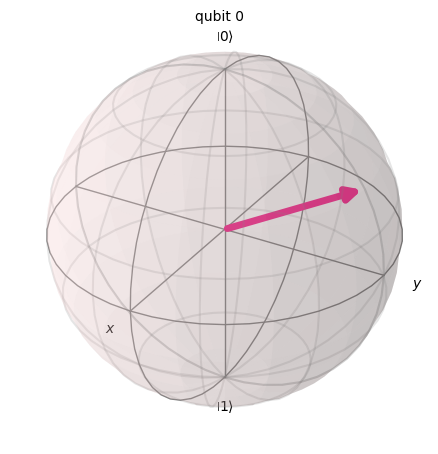

Teleported Qubit (Bob’s qubit):


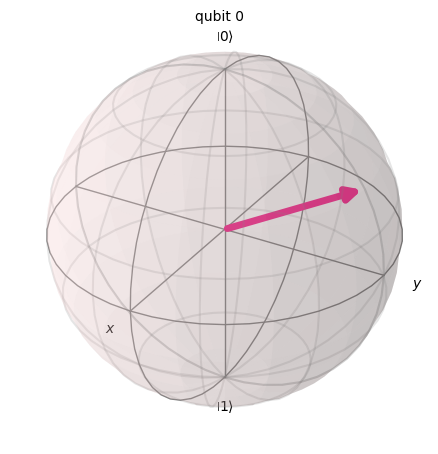

In [3]:
# Task 1: Custom State Teleportation – Explore how θ and φ affect teleportation
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

# ---------- Helper function ----------
def teleport_and_visualize(theta, phi):
    print(f"\n=== Teleportation for θ={theta:.2f} rad, φ={phi:.2f} rad ===")

    qc = QuantumCircuit(3)

    # Prepare custom state on qubit 0
    qc.ry(theta, 0)
    qc.rz(phi, 0)

    # Save initial state
    sv_initial = Statevector.from_instruction(qc)

    # Bell pair creation
    qc.h(1)
    qc.cx(1, 2)

    # Bell measurement (coherent)
    qc.cx(0, 1)
    qc.h(0)

    # Coherent corrections
    qc.cx(1, 2)
    qc.cz(0, 2)

    # Save statevector
    qc.save_statevector()

    # Simulate
    sim = AerSimulator()
    compiled = transpile(qc, sim)
    result = sim.run(compiled).result()
    sv_final = Statevector(result.data(0)["statevector"])

    # Extract Bob's qubit (qubit 2)
    rho_bob = partial_trace(sv_final, [0, 1])
    rho_init = partial_trace(sv_initial, [1, 2])

    # Convert to pure state vectors
    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
    eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
    bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
    init_state = eigvecs_i[:, np.argmax(eigvals_i)]

    # Fidelity
    fidelity = np.abs(np.vdot(init_state, bob_state))**2
    print(f"Fidelity between initial and teleported states: {fidelity:.6f}")

    # Visualize both on Bloch spheres
    print("\nInitial Qubit (|ψ⟩):")
    display(plot_bloch_multivector(Statevector(init_state)))
    print("Teleported Qubit (Bob’s qubit):")
    display(plot_bloch_multivector(Statevector(bob_state)))

# ---------- Try different theta and phi ----------
# Example experiments
for theta, phi in [(np.pi/4, 0), (np.pi/2, np.pi/4), (np.pi/3, np.pi/2)]:
    teleport_and_visualize(theta, phi)


Initial state of qubit 0:


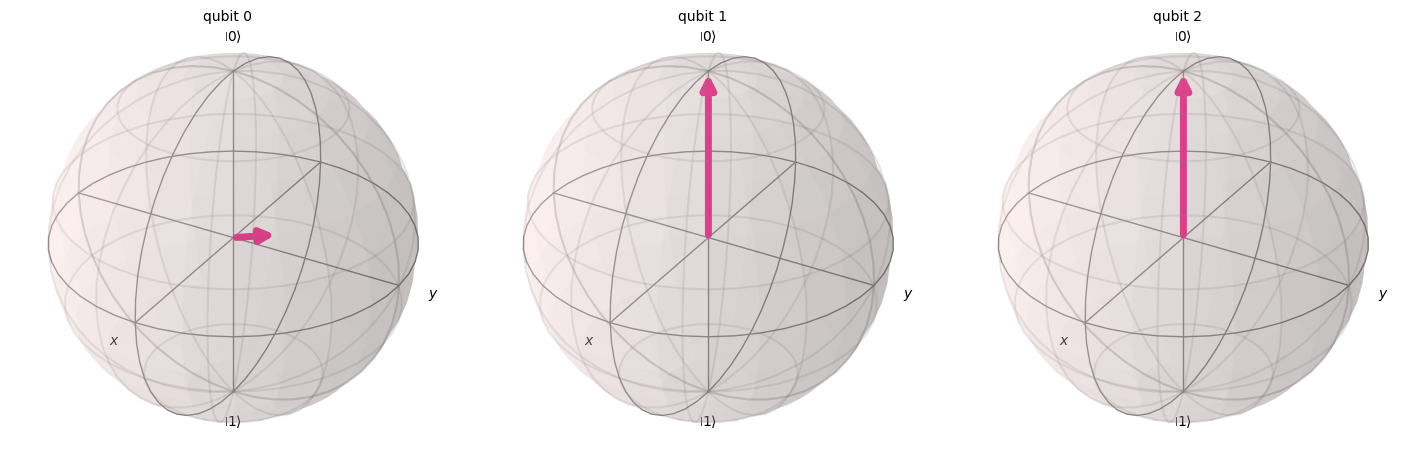

AttributeError: 'InstructionSet' object has no attribute 'to_instruction'

In [8]:
# Task 2: Quantum Teleportation with Classical Measurement and Conditional Corrections
from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector, partial_trace
import numpy as np

# --- Step 1: Build the teleportation circuit ---
qc = QuantumCircuit(3, 2)  # 3 qubits, 2 classical bits

# Prepare an arbitrary state on qubit 0
theta, phi = np.pi / 3, np.pi / 4
qc.ry(theta, 0)
qc.rz(phi, 0)

# Save initial state
sv_initial = Statevector.from_instruction(qc)
print("Initial state of qubit 0:")
display(plot_bloch_multivector(sv_initial))

# Create Bell pair between qubits 1 & 2
qc.h(1)
qc.cx(1, 2)

# Bell measurement on Alice’s qubits (0 and 1)
qc.cx(0, 1)
qc.h(0)
qc.measure(0, 0)
qc.measure(1, 1)

# --- Step 2: Conditional operations on Bob’s qubit (Qiskit 2.x compatible) ---
# Get instruction forms of gates
x_instr = qc.x(2).to_instruction()
z_instr = qc.z(2).to_instruction()

# Append with classical conditions using .append()
qc.append(x_instr, [2]).c_if(qc.cregs[0], 0b01)  # Apply X if bit1 = 1
qc.append(z_instr, [2]).c_if(qc.cregs[0], 0b10)  # Apply Z if bit0 = 1

# Save final statevector
qc.save_statevector()

# --- Step 3: Simulate ---
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()
sv_final = Statevector(result.data(0)["statevector"])

# --- Step 4: Compare initial vs teleported state ---
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])

eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]

# Fidelity
fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
print(f"\nFidelity between initial and teleported states: {fidelity:.6f}")

print("\nTeleported (Bob's) Qubit on Bloch Sphere:")
display(plot_bloch_multivector(Statevector(bob_state)))


In [10]:
from qiskit import QuantumCircuit, execute
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

# Function to create and run teleportation for given theta, phi
def teleportation_fidelity(theta, phi):
    qc = QuantumCircuit(3, 2)

    # Prepare custom input state |ψ⟩ = Rz(phi)Ry(theta)|0⟩
    qc.ry(theta, 0)
    qc.rz(phi, 0)

    # Create entangled pair (Bell state)
    qc.h(1)
    qc.cx(1, 2)

    # Bell measurement
    qc.cx(0, 1)
    qc.h(0)
    qc.measure([0, 1], [0, 1])

    # Conditional corrections on Bob’s qubit
    qc.z(2).c_if(qc.cregs[0], 1)
    qc.x(2).c_if(qc.cregs[0], 2)

    # Save statevector
    qc.save_statevector()

    # Run on simulator
    sim = Aer.get_backend('aer_simulator')
    result = sim.run(qc).result()
    final_state = result.get_statevector()

    # Original input state
    original_state = Statevector.from_instruction(
        QuantumCircuit(1).ry(theta, 0).rz(phi, 0)
    )

    # Bob’s qubit is the last one (index 2)
    bob_state = Statevector(final_state).partial_trace([0, 1])

    # Compute fidelity
    fidelity = state_fidelity(original_state, bob_state)
    return fidelity

# --- Run for multiple random states ---
num_samples = 20
thetas = np.random.uniform(0, np.pi, num_samples)
phis = np.random.uniform(0, 2*np.pi, num_samples)

fidelities = []

for t, p in zip(thetas, phis):
    fidelities.append(teleportation_fidelity(t, p))

# --- Plot results ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_samples + 1), fidelities, 'o-', label='Fidelity')
plt.axhline(np.mean(fidelities), color='r', linestyle='--', label=f'Average Fidelity = {np.mean(fidelities):.3f}')
plt.xlabel('Sample Index')
plt.ylabel('Fidelity')
plt.title('Quantum Teleportation Fidelity for Random States')
plt.legend()
plt.grid(True)
plt.show()

# --- Print summary ---
print(f"Average Fidelity over {num_samples} random states: {np.mean(fidelities):.4f}")


ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.12/dist-packages/qiskit/__init__.py)

🔹 After coherent corrections (CZ + CX)


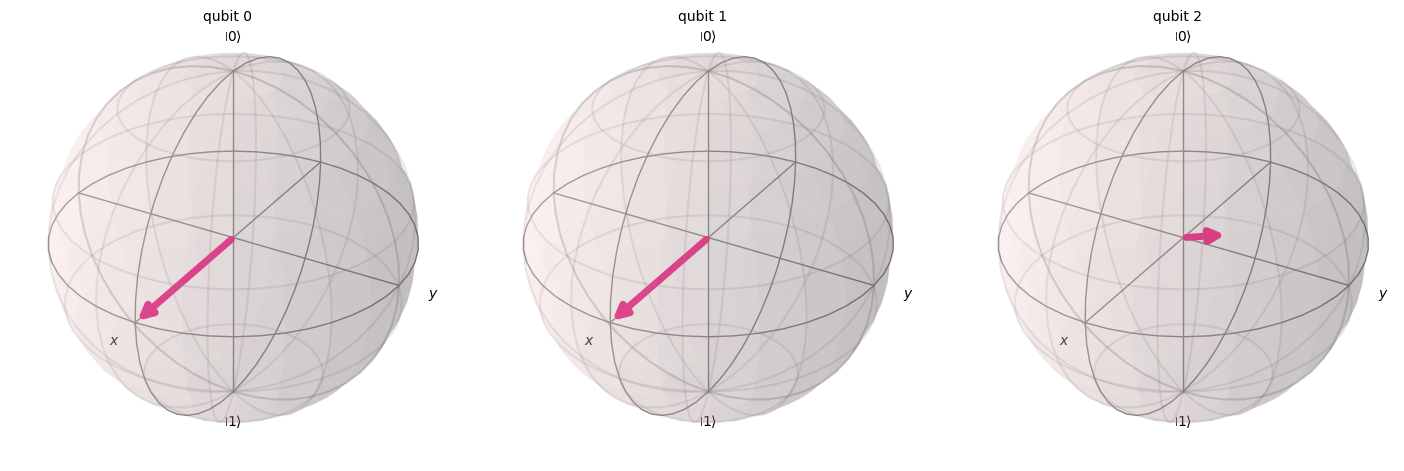

✅ Bob’s final qubit state:


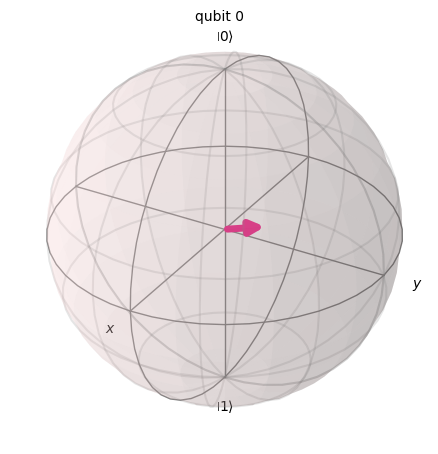

In [11]:
# Task 4: Step-by-Step Visualization of Quantum Teleportation
!pip install qiskit qiskit_aer pylatexenc -q

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
from IPython.display import display, clear_output
import numpy as np, time

def show_state(sv, step):
    clear_output(wait=True)
    print(f"🔹 {step}")
    display(plot_bloch_multivector(sv))
    time.sleep(1.3)

# Build teleportation circuit step-by-step
qc = QuantumCircuit(3)
theta, phi = np.pi/3, np.pi/4
qc.ry(theta, 0)
qc.rz(phi, 0)
sv = Statevector.from_instruction(qc)
show_state(sv, "Initial state |ψ⟩ prepared on qubit 0")

# Bell pair creation
qc.h(1)
qc.cx(1, 2)
sv = Statevector.from_instruction(qc)
show_state(sv, "After creating Bell pair between qubits 1 and 2")

# Bell measurement entanglement
qc.cx(0, 1)
qc.h(0)
sv = Statevector.from_instruction(qc)
show_state(sv, "After Bell measurement operations")

# Coherent correction
qc.cx(1, 2)
qc.cz(0, 2)
sv = Statevector.from_instruction(qc)
show_state(sv, "After coherent corrections (CZ + CX)")

# Bob's qubit visualization
rho_bob = partial_trace(sv, [0, 1])
print("✅ Bob’s final qubit state:")
display(plot_bloch_multivector(rho_bob))


In [15]:
# ✅ Task 5: Teleportation Fidelity Under Noise (Qiskit 2.x Compatible)
!pip install qiskit qiskit_aer pylatexenc -q

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error   # ✅ fixed import
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

# Build noise model (1% depolarizing on 1-qubit gates, 2% on 2-qubit gates)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ['ry','rz','h','x','z'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 2), ['cx'])

sim_noisy = AerSimulator(noise_model=noise_model)
fidelities = []

# Run for multiple random (theta, phi)
for i in range(15):
    theta, phi = np.random.uniform(0, np.pi), np.random.uniform(0, 2*np.pi)
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    qc.h(1); qc.cx(1, 2)
    qc.cx(0, 1); qc.h(0)
    qc.cx(1, 2); qc.cz(0, 2)
    qc.save_statevector()

    result = sim_noisy.run(transpile(qc, sim_noisy)).result()
    sv_final = Statevector(result.data(0)['statevector'])
    rho_bob = partial_trace(sv_final, [0,1])
    rho_init = partial_trace(Statevector.from_instruction(qc), [1,2])
    fidelity = state_fidelity(rho_init, rho_bob)
    fidelities.append(fidelity)

plt.figure(figsize=(6,4))
plt.plot(fidelities, marker='o')
plt.title("Teleportation Fidelity under Depolarizing Noise")
plt.xlabel("Experiment #")
plt.ylabel("Fidelity")
plt.ylim(0,1)
plt.grid(True)
plt.show()

print(f"Average fidelity: {np.mean(fidelities):.4f}")


QiskitError: 'Cannot apply Instruction: save_statevector'